In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [6]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [7]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= locations

In [8]:
#only not null, not zero and less that 10 hours to solve
df = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 36000) & (df['Respond to Available']!=0)]

In [9]:
df.shape

(2046497, 44)

In [61]:
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df1 = df.drop(columns=['Call Number', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Supervisor District', 'Original Priority',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay',  
                      'RowID', 'Battalion', 'ALS Unit'], errors='ignore')

In [62]:
df1 = df1.dropna(how='any') 

In [63]:
df1.shape

(2046213, 18)

In [64]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1432349 entries, 1 to 1650123
Data columns (total 17 columns):
Unit ID                                 1432349 non-null object
Call Type                               1432349 non-null object
Zipcode of Incident                     1432349 non-null int64
Station Area                            1432349 non-null object
Box                                     1432349 non-null float64
Number of Alarms                        1432349 non-null int64
Unit Type                               1432349 non-null object
Unit sequence in call dispatch          1432349 non-null int64
Fire Prevention District                1432349 non-null object
Neighborhooods - Analysis Boundaries    1432349 non-null object
Call to Dispatch                        1432349 non-null float64
Weekofyear                              1432349 non-null int64
Hours                                   1432349 non-null int64
Minutes                                 1432349 non-null i

In [66]:
cat_features=[
    0,
    1,
    3,
    6,
    8,
    9
]

In [67]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [119]:
model = CatBoostRegressor(iterations=400, depth=10,learning_rate=0.1)
model.fit(train_pool)

0:	learn: 2014.2305565	total: 3.85s	remaining: 25m 36s
1:	learn: 1874.7268494	total: 7.26s	remaining: 24m 4s
2:	learn: 1753.0775298	total: 10.1s	remaining: 22m 15s
3:	learn: 1647.7645719	total: 12.8s	remaining: 21m 2s
4:	learn: 1556.9096384	total: 16.2s	remaining: 21m 23s
5:	learn: 1478.9410021	total: 20.1s	remaining: 22m 1s
6:	learn: 1412.4654579	total: 23s	remaining: 21m 33s
7:	learn: 1355.4894147	total: 26.3s	remaining: 21m 30s
8:	learn: 1306.8955262	total: 29.9s	remaining: 21m 39s
9:	learn: 1265.2569568	total: 32.5s	remaining: 21m 9s
10:	learn: 1230.7342884	total: 35.9s	remaining: 21m 8s
11:	learn: 1202.2206791	total: 38.8s	remaining: 20m 52s
12:	learn: 1177.4916113	total: 41.9s	remaining: 20m 46s
13:	learn: 1157.0509987	total: 45.3s	remaining: 20m 47s
14:	learn: 1139.9434402	total: 49.7s	remaining: 21m 14s
15:	learn: 1125.8058868	total: 53.1s	remaining: 21m 14s
16:	learn: 1114.0853277	total: 57s	remaining: 21m 25s
17:	learn: 1104.0025982	total: 1m 1s	remaining: 21m 41s
18:	learn: 

145:	learn: 1001.2661979	total: 9m 17s	remaining: 16m 9s
146:	learn: 1001.1542988	total: 9m 21s	remaining: 16m 6s
147:	learn: 1000.9429364	total: 9m 25s	remaining: 16m 2s
148:	learn: 1000.8634948	total: 9m 28s	remaining: 15m 58s
149:	learn: 1000.4957517	total: 9m 32s	remaining: 15m 54s
150:	learn: 1000.3983033	total: 9m 36s	remaining: 15m 50s
151:	learn: 1000.3485401	total: 9m 39s	remaining: 15m 45s
152:	learn: 1000.1738424	total: 9m 43s	remaining: 15m 41s
153:	learn: 1000.0333754	total: 9m 47s	remaining: 15m 38s
154:	learn: 999.9193090	total: 9m 50s	remaining: 15m 33s
155:	learn: 999.7965140	total: 9m 54s	remaining: 15m 29s
156:	learn: 999.6493877	total: 9m 58s	remaining: 15m 25s
157:	learn: 999.5149540	total: 10m 2s	remaining: 15m 22s
158:	learn: 999.3101283	total: 10m 5s	remaining: 15m 18s
159:	learn: 999.1123938	total: 10m 9s	remaining: 15m 14s
160:	learn: 998.9733963	total: 10m 13s	remaining: 15m 11s
161:	learn: 998.8940228	total: 10m 17s	remaining: 15m 7s
162:	learn: 998.6579842	

289:	learn: 983.3684848	total: 18m 41s	remaining: 7m 5s
290:	learn: 983.1995449	total: 18m 44s	remaining: 7m 1s
291:	learn: 983.1413191	total: 18m 49s	remaining: 6m 57s
292:	learn: 982.9793461	total: 18m 53s	remaining: 6m 53s
293:	learn: 982.9377718	total: 18m 56s	remaining: 6m 49s
294:	learn: 982.7679149	total: 19m	remaining: 6m 45s
295:	learn: 982.7353041	total: 19m 4s	remaining: 6m 42s

Iteration with suspicious time 518 sec ignored in overall statistics.
296:	learn: 982.6448945	total: 19m 4s	remaining: 6m 42s
297:	learn: 982.5803993	total: 19m 14s	remaining: 6m 36s
298:	learn: 982.4107546	total: 19m 19s	remaining: 6m 33s
299:	learn: 982.2863905	total: 19m 24s	remaining: 6m 29s
300:	learn: 982.2201209	total: 19m 29s	remaining: 6m 25s
301:	learn: 981.9817257	total: 19m 34s	remaining: 6m 22s
302:	learn: 981.9145633	total: 19m 38s	remaining: 6m 18s
303:	learn: 981.7192552	total: 19m 42s	remaining: 6m 14s
304:	learn: 981.5082262	total: 19m 45s	remaining: 6m 10s
305:	learn: 981.4202446	t

In [120]:
model.score(test_pool, y_test)  #

990.0923387432147

In [121]:
pred = model.predict(test_pool)

In [122]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(5)

,Unit ID,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Neighborhooods - Analysis Boundaries,Call to Dispatch,Weekofyear,Hours,Minutes,Hospital or Transport,0,1,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1650124,E31,Medical Incident,94121,31,7164.0,1,ENGINE,1,7,Outer Richmond,87.0,23,15,14,0,37.783238,-122.478580,936.0,801.775215,134.224785,18016.292866,1562.266912,-626.266912
1650125,M22,Medical Incident,94121,31,7164.0,1,MEDIC,2,7,Outer Richmond,87.0,23,15,14,1,37.783238,-122.478580,3200.0,3691.100280,-491.100280,241179.485238,1562.266912,1637.733088
1650126,RS1,Medical Incident,94102,1,1365.0,1,RESCUE SQUAD,3,3,Tenderloin,81.0,23,15,28,0,37.783789,-122.409266,156.0,249.215165,-93.215165,8689.066919,1562.266912,-1406.266912
1650127,92,Medical Incident,94103,1,2251.0,1,MEDIC,1,3,South of Market,160.0,23,15,19,1,37.780136,-122.408771,4081.0,3396.177298,684.822702,468982.133037,1562.266912,2518.733088
1650128,E01,Medical Incident,94103,1,2251.0,1,ENGINE,2,3,South of Market,160.0,23,15,19,0,37.780136,-122.408771,150.0,487.919785,-337.919785,114189.781341,1562.266912,-1412.266912


In [123]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [124]:
mae

593.0798335809429

In [125]:
mse

980282.8392380085

In [126]:
rmse

990.0923387432147

In [127]:
determanation_score

0.65625171760731

In [106]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1325.7209902110242
mse_mean: 2866229.987544824
mrse_mean: 1692.9943849714398


In [128]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Unit ID', 3.932413777686254),
 ('Call Type', 6.130328836305738),
 ('Zipcode of Incident', 1.8494781360752524),
 ('Station Area', 1.988241155337167),
 ('Box', 3.1021904948793835),
 ('Number of Alarms', 14.968771762838667),
 ('Unit Type', 10.776805117492124),
 ('Unit sequence in call dispatch', 7.0993004362047945),
 ('Fire Prevention District', 1.6180963779997706),
 ('Neighborhooods - Analysis Boundaries', 1.3331220718336065),
 ('Call to Dispatch', 3.191598024274712),
 ('Weekofyear', 1.1338771339599858),
 ('Hours', 4.258816271562817),
 ('Minutes', 1.1121245520101537),
 ('Hospital or Transport', 32.70570246032967),
 (0, 2.3336840360283553),
 (1, 2.465449355181562)]

[('Battalion', 0.5078027445356504),
 ('Station Area', 6.135001357254266),
 ('Box', 9.114046028348575),
 ('Original Priority', 1.9631004892661137),
 ('ALS Unit', 0.8674294353822795),
 ('Call Type Group', 3.333459641176911),
 ('Unit Type', 41.73743300645736),
 ('Fire Prevention District', 1.5738692854230882),
 ('Supervisor District', 1.5693252610655513),
 ('Month', 0.5003596981995669),
 ('WeekDay', 0.7519625648056559),
 ('Weekofyear', 1.623724419771495),
 ('Hours', 8.179958110857296),
 ('Minutes', 1.0530441606569498),
 ('Call Type Merged', 21.08948379679924)]
 
 [('Station Area', 6.994516107181966),
 ('Box', 5.876354709490432),
 ('Original Priority', 0.9627007503785607),
 ('Call Type Group', 1.29599635276719),
 ('Unit Type', 60.51084666020504),
 ('Fire Prevention District', 0.3122714646717646),
 ('Supervisor District', 0.5588749902917611),
 ('Weekofyear', 0.0),
 ('Hours', 3.0604472528149556),
 ('Minutes', 0.0),
 ('Call Type Merged', 20.427991712198327)]

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

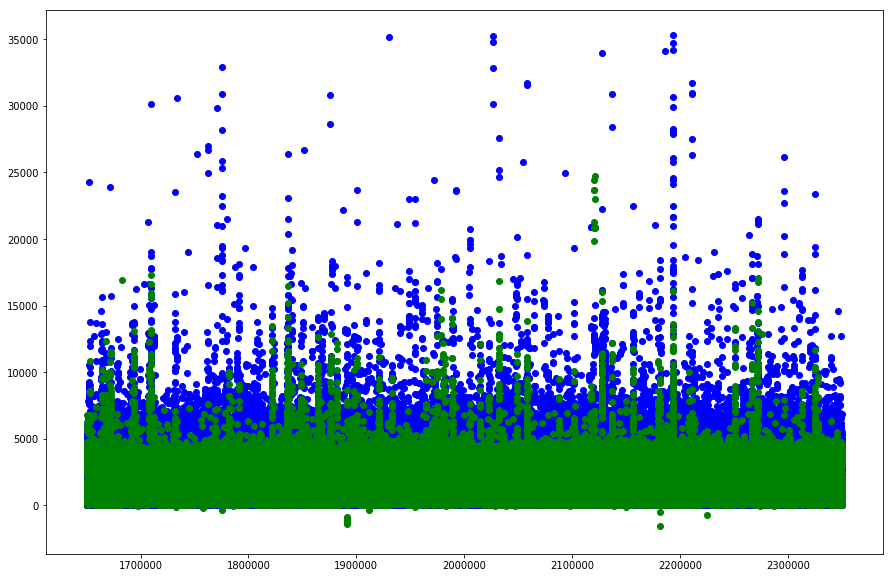

In [129]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

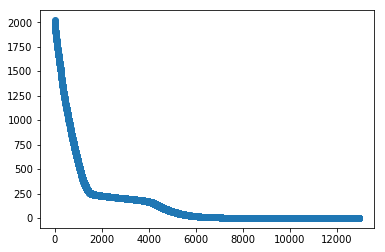

In [47]:
plt.scatter(range(0,12957), df1['Respond to Available'].value_counts())

In [82]:
df1[df1['Respond to Available']> 25n000].count()  #2046293

Unit ID                                 191
Call Type                               191
Zipcode of Incident                     191
Station Area                            191
Box                                     191
Number of Alarms                        191
Unit Type                               191
Unit sequence in call dispatch          191
Fire Prevention District                191
Neighborhooods - Analysis Boundaries    191
Respond to Available                    191
Call to Dispatch                        191
Weekofyear                              191
Hours                                   191
Minutes                                 191
Hospital or Transport                   191
0                                       191
1                                       191
dtype: int64

###### df1[df['Respond to Available']==0]

389